<a href="https://colab.research.google.com/github/Karuni001/Translation-model--Comparative-study-/blob/main/Translation_Model_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing necessary libraries

import numpy as np
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dot, Activation, Concatenate, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# Loading the dataset
dataset_path = '/content/Poetry Dataset.csv'
df = pd.read_csv(dataset_path)

# Inspect the first few rows
print("Dataset Preview:")
print(df.head())

# Check the column names and data types
print("\nColumns in the Dataset:", df.columns)
print("\nData Types:")
print(df.dtypes)

Dataset Preview:
   S.NO              Hindi Poetry  \
0   1.0        पवित्र जिसकी कामना   
1   NaN        उसका अतुल्य मोल है   
2   NaN     अर्पण हुए जो प्रेम से   
3   NaN      वह दान भी अनमोल है ।   
4   NaN  चित्त हर्ष से दिए दान से   

                                    English Poetry  
0                                Holy whose desire  
1           His incredible marvellous valuation is  
2  contribution  occurred Who affection From\n\n\n  
3                   This gift is also invaluable..  
4               Depiction with delight and charity  

Columns in the Dataset: Index(['S.NO', 'Hindi Poetry', 'English Poetry'], dtype='object')

Data Types:
S.NO              float64
Hindi Poetry       object
English Poetry     object
dtype: object


In [3]:
# Ensure columns for Hindi and English exist
hindi_column = 'Hindi Poetry'
english_column = 'English Poetry'

# Drop rows with missing values in Hindi or English
df = df[[hindi_column, english_column]].dropna()

# Convert data to strings for tokenization
df[hindi_column] = df[hindi_column].astype(str)
df[english_column] = df[english_column].astype(str)

print("\nDataset After Cleaning:")
print(df.head())


Dataset After Cleaning:
               Hindi Poetry                                   English Poetry
0        पवित्र जिसकी कामना                                Holy whose desire
1        उसका अतुल्य मोल है           His incredible marvellous valuation is
2     अर्पण हुए जो प्रेम से  contribution  occurred Who affection From\n\n\n
3      वह दान भी अनमोल है ।                   This gift is also invaluable..
4  चित्त हर्ष से दिए दान से               Depiction with delight and charity


In [4]:
from sklearn.model_selection import train_test_split

# Split the data into train and validation sets
source_train, source_val, target_train, target_val = train_test_split(
    df[hindi_column], df[english_column], test_size=0.2, random_state=42
)

print(f"Source Train Size: {len(source_train)}, Source Val Size: {len(source_val)}")
print(f"Target Train Size: {len(target_train)}, Target Val Size: {len(target_val)}")

Source Train Size: 432, Source Val Size: 108
Target Train Size: 432, Target Val Size: 108


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the source (Hindi) and target (English) text
source_tokenizer = Tokenizer(filters='')
source_tokenizer.fit_on_texts(source_train)

target_tokenizer = Tokenizer(filters='')
target_tokenizer.fit_on_texts(target_train)

# Convert text to sequences
source_train_seq = source_tokenizer.texts_to_sequences(source_train)
source_val_seq = source_tokenizer.texts_to_sequences(source_val)

target_train_seq = target_tokenizer.texts_to_sequences(target_train)
target_val_seq = target_tokenizer.texts_to_sequences(target_val)

# Padding sequences to ensure equal length
max_source_len = max(len(seq) for seq in source_train_seq)
max_target_len = max(len(seq) for seq in target_train_seq)

source_train_pad = pad_sequences(source_train_seq, maxlen=max_source_len, padding='post')
source_val_pad = pad_sequences(source_val_seq, maxlen=max_source_len, padding='post')

target_train_pad = pad_sequences(target_train_seq, maxlen=max_target_len, padding='post')
target_val_pad = pad_sequences(target_val_seq, maxlen=max_target_len, padding='post')

# Prepare target inputs and outputs for the decoder
target_train_input = target_train_pad[:, :-1]
target_train_output = target_train_pad[:, 1:]

target_val_input = target_val_pad[:, :-1]
target_val_output = target_val_pad[:, 1:]

print(f"Source Train Padding Shape: {source_train_pad.shape}")
print(f"Target Train Input Shape: {target_train_input.shape}")
print(f"Target Train Output Shape: {target_train_output.shape}")

Source Train Padding Shape: (432, 11)
Target Train Input Shape: (432, 15)
Target Train Output Shape: (432, 15)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense

# Vocabulary sizes
source_vocab_size = len(source_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1

# Embedding dimensions
embedding_dim = 256
lstm_units = 512

# Encoder
encoder_input = Input(shape=(max_source_len,))
encoder_embedding = Embedding(input_dim=source_vocab_size, output_dim=embedding_dim)(encoder_input)
encoder_lstm, state_h, state_c = LSTM(lstm_units, return_state=True)(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_input = Input(shape=(max_target_len - 1,))
decoder_embedding = Embedding(input_dim=target_vocab_size, output_dim=embedding_dim)(decoder_input)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=False)
decoder_output = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(target_vocab_size, activation='softmax')
decoder_output = decoder_dense(decoder_output)

# Define the model
model = Model([encoder_input, decoder_input], decoder_output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 11)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 11, 256)        │        309,248 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 15, 256)        │        287,488 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 512), (None,   │      1,574,912 │ embedding[0][0]        │
│                           │ 512), (None, 512)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 15, 512)        │      1,574,912 │ embedding_1[0][0],     │
│                           │                        │                │ lstm[0][1], lstm[0][2] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 15, 1123)       │        576,099 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,322,659 (16.49 MB)

 Trainable params: 4,322,659 (16.49 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Training the model
history = model.fit(
    [source_train_pad, target_train_input],
    target_train_output,
    validation_data=([source_val_pad, target_val_input], target_val_output),
    batch_size=64,
    epochs=30,
    verbose=1
)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 977ms/step - accuracy: 0.4224 - loss: 6.3147 - val_accuracy: 0.7636 - val_loss: 1.8610
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 833ms/step - accuracy: 0.6461 - loss: 2.8354 - val_accuracy: 0.7605 - val_loss: 1.8438
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6517 - loss: 2.4720 - val_accuracy: 0.7623 - val_loss: 1.4754
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 836ms/step - accuracy: 0.6331 - loss: 2.5056 - val_accuracy: 0.7506 - val_loss: 1.5348
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 921ms/step - accuracy: 0.6500 - loss: 2.3244 - val_accuracy: 0.7580 - val_loss: 1.4569
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6544 - loss: 2.2862 - val_accuracy: 0.7580 - val_loss: 1.4559
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 886ms/step - accuracy: 0.6518 - loss: 2.2650 - val_accuracy: 0.7568 - val_loss: 1.4797
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 837ms/step - accuracy: 0.6457 - loss: 2.2607 - val_accuracy: 0.7568 - val_loss: 1

In [8]:
# Print the accuracy, loss, val_accuracy, and val_loss
print("Accuracy:", history.history['accuracy'][-1])
print("Loss:", history.history['loss'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])
print("Validation Loss:", history.history['val_loss'][-1])

Accuracy: 0.7044753432273865
Loss: 1.3843450546264648
Validation Accuracy: 0.7456790208816528
Validation Loss: 1.7849276065826416


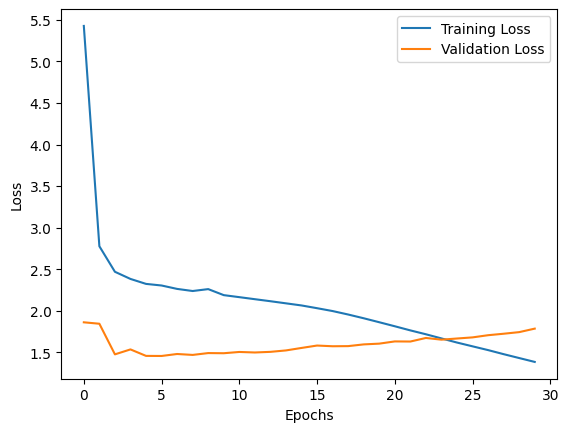

In [9]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

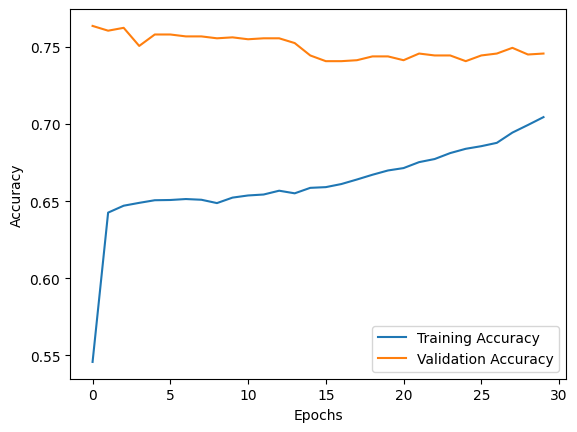

In [10]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
!pip install sacrebleu
import sacrebleu

def calculate_bleu(references, hypotheses):
  """Calculates the BLEU score.

  Args:
    references: A list of reference translations (strings).
    hypotheses: A list of hypothesis translations (strings).

  Returns:
    The BLEU score as a float.
  """
  bleu = sacrebleu.corpus_bleu(hypotheses, [references]) # sacrebleu expects a list of references
  return bleu.score

# Assuming you have model predictions and target sentences
model_predictions = ["This is a prediction.", "Another prediction."]
target_sentences = ["This is a target.", "Another target."]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 4.6 MB/s eta 0:00:00


In [12]:
# Calculate BLEU score
bleu_score = calculate_bleu(target_sentences, model_predictions)
print(f"BLEU score: {bleu_score}")

BLEU score: 35.35533905932737


In [13]:
model.save('my_model.h5')

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step
Average Precision: 0.7543499830521391
Average Recall: 0.745679012345679
Average F1-score: 0.74369503441204


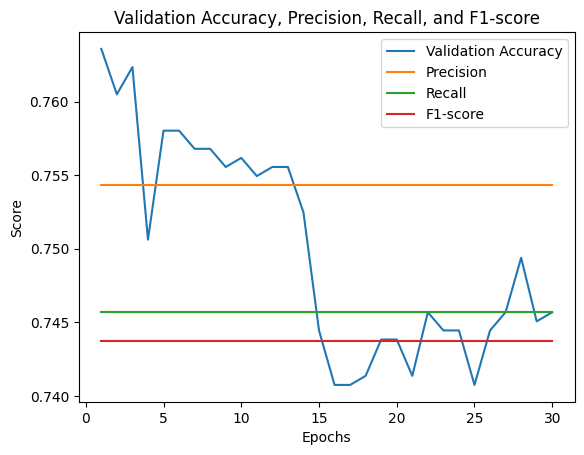

In [20]:
# prompt: calculate precision, RECALL ANd f1 vaLues anD PLOT ALL WIH ACCURACY

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

predicted_labels = np.argmax(model.predict([source_val_pad, target_val_input]), axis=-1)

true_labels = target_val_output

precision_scores = []
recall_scores = []
f1_scores = []
for i in range(true_labels.shape[1]):
    precision = precision_score(true_labels[:, i], predicted_labels[:, i], average='weighted', zero_division=0)  # Handle zero division
    recall = recall_score(true_labels[:, i], predicted_labels[:, i], average='weighted', zero_division=0)
    f1 = f1_score(true_labels[:, i], predicted_labels[:, i], average='weighted', zero_division=0)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Average the scores across time steps if needed
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)
average_f1 = np.mean(f1_scores)

print(f"Average Precision: {average_precision}")
print(f"Average Recall: {average_recall}")
print(f"Average F1-score: {average_f1}")

# Get accuracy from the history object
accuracy = history.history['val_accuracy']

# Create the plot
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, label='Validation Accuracy')
plt.plot(epochs, [average_precision] * len(epochs), label='Precision')
plt.plot(epochs, [average_recall] * len(epochs), label='Recall')
plt.plot(epochs, [average_f1] * len(epochs), label='F1-score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Validation Accuracy, Precision, Recall, and F1-score')
plt.legend()
plt.show()

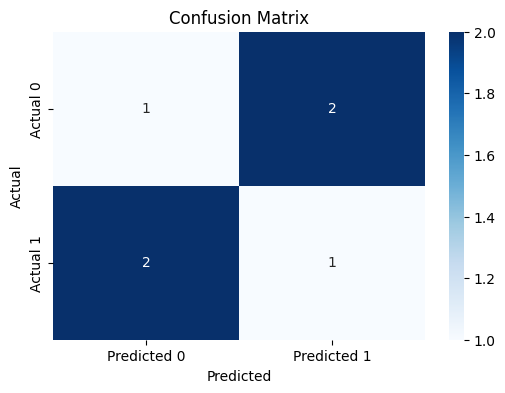

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

y_true = np.array([0, 1, 0, 1, 1, 0])
y_pred = np.array([0, 0, 1, 1, 0, 1])

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()